In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

import requests
import json

In [2]:
# specify data directory and file
data_dir = '/srv/zooniverse/raw_data/panoptes/all-panoptes-classifications-2017-01-30.csv'
# read csv file of panoptes classifications
classification_df = pd.read_csv(data_dir)

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# create a project dataframe that contains the total number of classifications per project
project_df = classification_df.groupby('project_id').size().to_frame('panoptes_dump_classification_count')
# get the workflow IDs for each project and store as a list
project_df = project_df.merge(classification_df.groupby('project_id')['workflow_id'].unique().to_frame('panoptes_dump_workflows'),left_index=True,right_index=True)
# reset index
project_df = project_df.reset_index()
# create 'panoptes_dump' column
project_df['panoptes_dump'] = 1
# rename project_id field for merge later
project_df = project_df.rename(columns={'project_id':'panoptes_project_id'})

In [9]:
# set the API endpoint
base_url = r'https://panoptes.zooniverse.org/api/projects'
# set necessary headers for zooniverse API
headers = {
    'Accept':'application/vnd.api+json; version=1',
    'Content-Type':'application/json'
}
params = {}
api_result_df = pd.DataFrame()
while True:
    # send and recieve HTTP request to API endpoint
    r = requests.get(base_url,
                    params=params,
                    headers=headers)
    # convert the result to JSON
    api_result = r.json()
    # iterate through each project in a page of API results
    for project in api_result['projects']:
        # collect relivant fields from json
        api_result_dict = {
            'panoptes_project_id':project['id'],
            'panoptes_project_name':project['display_name'],
            'panoptes_migrated':project['migrated'],
            'panoptes_description':project['description'],
            'panoptes_live':project['live'],
            'panoptes_launch_date':project['launch_date'],
            'panoptes_completeness':project['completeness'],
            'panoptes_api_subject_count':project['subjects_count'],
            'panoptes_api_classificaitons_count':project['classifiers_count'],
            'panoptes_api_topics':project['tags']
        }
        # collect the workflow information if it exists
        # this is useful for comparing dump results against API results
        if 'workflows' in project['links']:
            api_result_dict['panoptes_api_workflows'] = project['links']['workflows']
        else:
            api_result_dict['panoptes_api_workflows'] = None
        # collect the project roles if they're listed
        if 'project_roles' in project['links']:
            api_result_dict['panoptes_api_roles'] = project['links']['project_roles']
        else:
            api_result_dict['panoptes_api_roles'] = None
        if project['launch_approved']:
            api_result_dict['panoptes_api_official_project'] = 1
        else:
            api_result_dict['panoptes_api_official_project'] = 0
        # add the project data to the projects dataframe
        api_result_df = api_result_df.append(pd.DataFrame([api_result_dict]))
    
    # if there is another page of search results, add that href to the next query
    # else return the API result
    if api_result['meta']['projects']['next_href']:
        params['page'] = api_result['meta']['projects']['next_href'].split('=')[-1]
        print(api_result['meta']['projects']['next_href'])
    else:
        break
        
# convert the project ID from a string to a numeric field
api_result_df['panoptes_project_id'] = pd.to_numeric(api_result_df['panoptes_project_id'])
# create a panoptes_api field
api_result_df['panoptes_api'] = 1
    

/projects?page=2
/projects?page=3
/projects?page=4
/projects?page=5
/projects?page=6
/projects?page=7
/projects?page=8
/projects?page=9
/projects?page=10
/projects?page=11
/projects?page=12
/projects?page=13
/projects?page=14
/projects?page=15
/projects?page=16
/projects?page=17
/projects?page=18
/projects?page=19
/projects?page=20
/projects?page=21
/projects?page=22
/projects?page=23
/projects?page=24
/projects?page=25
/projects?page=26
/projects?page=27
/projects?page=28
/projects?page=29
/projects?page=30
/projects?page=31
/projects?page=32
/projects?page=33
/projects?page=34
/projects?page=35
/projects?page=36
/projects?page=37
/projects?page=38
/projects?page=39
/projects?page=40
/projects?page=41
/projects?page=42
/projects?page=43
/projects?page=44
/projects?page=45
/projects?page=46
/projects?page=47
/projects?page=48
/projects?page=49
/projects?page=50


In [10]:
joined_df = api_result_df.merge(project_df,on='panoptes_project_id',how='outer')

In [11]:
# set NaN values to 0
joined_df.loc[joined_df['panoptes_dump'].isnull(),'panoptes_dump'] = 0
joined_df.loc[joined_df['panoptes_api'].isnull(),'panoptes_api'] = 0

In [12]:
# drop non-uniques base on panoptes_project_id
joined_df = joined_df.drop_duplicates(subset='panoptes_project_id',keep='first')

# Project Overlap Stats

In [14]:
print('panoptes dump: {0}'.format(len(joined_df.loc[joined_df['panoptes_dump'] == 1])))
print('panoptes api: {0}'.format(len(joined_df.loc[joined_df['panoptes_api'] == 1])))
print('overlap between panoptes dump + api: {0}'.format(len(joined_df.loc[(joined_df['panoptes_dump'] == 1) & (joined_df['panoptes_api'] == 1)])))

panoptes dump: 750
panoptes api: 987
panoptes dump + api: 299


# Official Project Overlap Stats

In [15]:
print('official_projects: {0}'.format(len(joined_df.loc[joined_df['panoptes_api_official_project'] == 1])))
print('non-official_projects: {0}'.format(len(joined_df.loc[joined_df['panoptes_api_official_project'] == 0])))
print('project IDs in dump without API result: {0}\n'.format(len(joined_df.loc[joined_df['panoptes_api_official_project'].isnull()])))

print('PANOPTES DUMP + API')
print('official_projects: {0}'.format(len(joined_df.loc[(joined_df['panoptes_api_official_project'] == 1) & (joined_df['panoptes_dump'] == 1) & (joined_df['panoptes_api'] == 1)])))
print('non-official_projects: {0}'.format(len(joined_df.loc[(joined_df['panoptes_api_official_project'] == 0) & (joined_df['panoptes_dump'] == 1) & (joined_df['panoptes_api'] == 1)])))
#print('no result: {0}\n'.format(len(joined_df.loc[(joined_df['panoptes_api_official_project'].isnull()) & (joined_df['panoptes_dump'] == 1) & (joined_df['panoptes_api'] == 1)])))

official_projects: 162
non-official_projects: 825
project IDs in dump without API result: 451

PANOPTES DUMP + API
official_projects: 65
non-official_projects: 234


In [16]:
# make a df of only official panoptes projects
official_projects_df = joined_df.loc[joined_df['panoptes_api_official_project'] == 1]
official_projects_df = official_projects_df.loc[official_projects_df['panoptes_dump_classification_count'].notnull()]

# Official Project Names

In [17]:
official_projects_df['panoptes_project_name'].values

array(['Steller Watch', 'Backyard Worlds: Planet 9', 'Camera CATalogue',
       'Comet Hunters', 'Western Montana Wildlife', 'Bash the Bug',
       'Wildwatch Kenya',
       'The Community Seagrass Initiative - Seagrass Explorer',
       'Season Spotter Image Marking', 'WildCam Gorongosa',
       'Galaxy Nurseries', 'Season Spotter Questions',
       'Steelpan Vibrations', 'Serengeti Wildebeest Count', 'Seabirdwatch',
       'Fossil Atmospheres', 'AmazonCam Tambopata', 'Notes from Nature',
       'Exoplanet Explorers', 'Western Shield — Camera Watch',
       'Colorado Corridors Project', 'Radio Meteor Zoo',
       'African American Civil War Soldiers', 'Milky Way Project',
       "Shakespeare's World", 'Gravity Spy',
       'SCOTUS Notes: Behind the Scenes at Supreme Court Conference',
       'Canid Camera', 'Focus on Wildlife -- Cleveland Metroparks',
       "Poppin' Galaxy", 'Snow Spotter', 'Etch a Cell',
       'Planet Four: Ridges', 'Decoding the Civil War', 'Brain Match',
       '

In [29]:
# unpack lists of workflows where each workflow is a row
workflows = official_projects_df.apply(lambda x: pd.Series(x['panoptes_api_workflows']),axis=1).stack().reset_index(level=1, drop=True).to_frame('workflows')
# count the number of each workflow
workflows = workflows.groupby('workflows').size().to_frame('count')

# All workflows are unique to each project

In [28]:
workflows.describe()

,count
count,1552.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [11]:
# unpack lists of topics where each topic is a row
topics = official_projects_df.apply(lambda x: pd.Series(x['panoptes_api_topics']),axis=1).stack().reset_index(level=1, drop=True).to_frame('topics')
# count the number of each topic
topics = topics.groupby('topics').size().to_frame('count')

# Summary Stats for Topic Overlap Between Projects

In [12]:
topics.describe()

,count
count,212.000000
mean,2.169811
std,4.035322
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,36.000000


# Histogram Illustrating the Distribution of Projects Topics

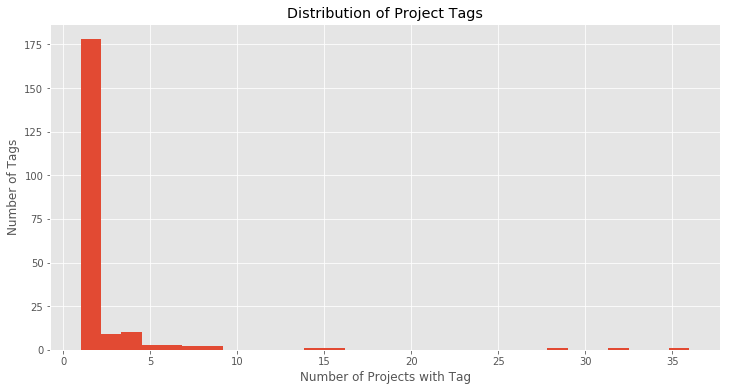

In [13]:
plt.figure(figsize=(12,6))
plt.hist(topics['count'],bins=30)
plt.title('Distribution of Project Tags')
plt.xlabel('Number of Projects with Tag')
plt.ylabel('Number of Tags')

# List of topics that occur more than once

In [14]:
topics.loc[topics['count'] > 1]

,count
topics,
biology,4
climate change,2
conservation,2
history,2
a,28
africa,4
amazon,2
animals,5
arts,4
